# Predicció accidents vasculars cerebrals

### NOM I COGNOMS:  Jordi Gual Obradors | Daniel Lijia Hu

# 1. Descripció del dataset. Perquè és important i quina pregunta/problema pretén respondre? 

Està extreta del dataset original penjat a Kaggle per Fede Soriano. https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

### Context:  

Segons la Organització Mundial per a la Salut, els accidents vasculars cerebrals (AVC) són la segona causa de mort a nivell mundial, responsables de prop del 11% de les morts totals.

Aquest conjunt de dades s'utilitza per a predir la probabilitat d'AVC per a un pacient a partir de dades com ara gènere, edat, historial mèdic i adicció al tabac. Cada filera correspon a informació rellevant per a cada pacient. Aquesta predicció pot ajudar a identificar aquestes persones susceptibles a patir un infart i poder prevenir-lo o predir-lo abans que succeeixi l'esdeveniment

El dataset es composa de 5110 registres diferents amb 12 variables diferents. Aquests variables són:

### Informació dels atributs. 

* 1.- id: Identificador únic
* 2.- gender: "Male", "Female" or "Other". El pacient s'identifica com a masculí, femení o altre gènere
* 3.- age: Edat del pacient
* 4.- hypertension: 0 si el pacient no té hipertensió, 1 si el pacient pateix hipertensió.
* 5.- heart_disease: 0 si el pacient no té malaltia cardíaca, 1 si en té.
* 6.- ever_married: Casat alguna vegada. "No" or "Yes"
* 7.- work_type: Tipus de feina. "children" si són menors d'edat i no han treballat, "govt_jov" si són funcionaris, "never_worked" si no han treballat mai, "private" si treballen com a empleat en una empresa privada i "self-employed" si són autònoms
* 8.- Residence_type: Tipus de residència "Rural" o "Urban"
* 9.- avg_glucose_level: Nivell promig de glucèmia.
* 10.- bmi: IMC. Índex de massa corporal = Pes(kg)/(alçada(m))**2.
* 11.- smoking_status: "formerly smoked" (Ex-fumador), "never smoked" (No ha fumat mai), "smokes" (Fumador) o "Unknown" (Desconegut, info no disponible)
* 12.- stroke: 1 si el pacient ha patit un ACV, 0 si no. És la classe a predir.

Importació de llibreries utilitzades:

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import pylab
from scipy import stats
from scipy.stats import norm
from pandas_profiling import ProfileReport
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Importing the SMOTE-NC
from imblearn.over_sampling import SMOTENC



Càrrega de les dades

In [23]:
# Dataset Import and working copy generation
raw_data = pd.read_csv('./healthcare-dataset-stroke-data.csv')
df = raw_data.copy()
df.head(10)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


Primeres informacions del dataset

In [24]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 2. Integració i selecció de les dades d’interès a analitzar

Com es veu, el dataset original es composa de 5110 registres diferents amb 12 variables. Seleccionarem les dades les quals tenim un registre complet o rellevant estadísticament.

* Tenim dotze atributs, 7 dels quals són numèrics i els altres 5 categòrics, un d'ells booleà.

* El conjunt de dades es presenta força net, destacant tant sols l'absència de 201 valors de l'índex de massa corporal. No es pot derivar aquesta informació de cap manera a partir de les altres dades. Aquesta variable, però, té una alta correlació amb el tipus de treball, de manera que podríem substituir els na's per la mitjana corresponent a cadascún dels tipus de treball. De tota manera, suposen el 0.3% dels registres i optarem simplement per **eliminar-los**.

* La primera columna és un identificador del pacient que no ens aportarà informació per a l'estudi i l'eliminarem.

* Tenim un únic registre que presenta un gènere que no és ni masculí ni femení. També l'eliminarem perquè no aporta una dada estadística rellevant.

* Punts a tenir en compte:
    * Forta correlació entre ever_married i smoking_status. També amb l'edat.
    * Forta correlació entre tipus de treball i l'edat i amb l'IMC.
    * Forta correlació entre tipus de treball i 'Mai casat?'.
    
* Poblacions desequilibrades en els atributs 'hypertension' i 'heart_disease'.
* Les classes a determinar ('stroke') també estan molt desequilibrades (4861 valors 0 i 249 valors 1).

# 3. Neteja de les dades.

## 3.1. Les dades contenen zeros o elements buits? Com gestionaries aquests casos? 

* Com s'ha mencionat anteriorment, hi havia alguns registres que teníen buit l'atribut IMC. S'ha optat per esborrar-los ja que representen el 0.3% dels registres.

## 3.2. Identificació i tractament de valors extrems. 

* Pel que fa a valors extrems, aquests es donen en l'atribut IMC (bmi). Segons definició, serien valors extrems tots aquells majors que Q3 + 1.5*(Q3 + Q1) = 47.5. Calcularem quants pacients són, i si eliminar-los pot fer variar els resultats. 

In [25]:
# Remove bmi's na
df = df.dropna()

# Remove id column
df = df.drop(columns=['id'])

# Remove 'Other' sex register 
df = df[df.gender != 'Other']

# Last show a summary of clean data
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Ara ja només ens queden 5110 - 201 - 1 = 4908 registres on no  hi ha na's al bmi ni Other al gender. Passem a analitzar el tema outliers. L'atribut amb major presència d'outliers és el bmi. Definim outliers com aquells valors que superen en 1.5 vegades el valor interquartilic, comptant a partir del Q3. En el cas de bmi aquesta condició proporciona un valor de 47.5. Anem ara a veure quants pacients amb bmi extrem tenim:

In [26]:
fatties = df[df.bmi > 47.5]
fatties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 21 to 5057
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             110 non-null    object 
 1   age                110 non-null    float64
 2   hypertension       110 non-null    int64  
 3   heart_disease      110 non-null    int64  
 4   ever_married       110 non-null    object 
 5   work_type          110 non-null    object 
 6   Residence_type     110 non-null    object 
 7   avg_glucose_level  110 non-null    float64
 8   bmi                110 non-null    float64
 9   smoking_status     110 non-null    object 
 10  stroke             110 non-null    int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 10.3+ KB


Tenim 110 pacients amb un índex elevat de massa corporal. Els podríem eliminar o no sobretot en funció de quína proporció representen respecte als que tenen o no un AVC. Ja anem prou justos de valors amb stroke = 1 com per desprendre's de cap més!

In [27]:
stroked_fatties = fatties[fatties.stroke==1]
stroked_fatties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 21 to 113
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             2 non-null      object 
 1   age                2 non-null      float64
 2   hypertension       2 non-null      int64  
 3   heart_disease      2 non-null      int64  
 4   ever_married       2 non-null      object 
 5   work_type          2 non-null      object 
 6   Residence_type     2 non-null      object 
 7   avg_glucose_level  2 non-null      float64
 8   bmi                2 non-null      float64
 9   smoking_status     2 non-null      object 
 10  stroke             2 non-null      int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 192.0+ bytes


Els pacients amb un ídndex elevat de massa corporal representen 2/110 = 1.8% dels pacients amb AVC mentre que en general tenim un 4.9%. Per tant, comptar-los o no serà poc influent. No obstant això, optem per no excloure'ls. 

# 4. Anàlisi de les dades. 

## 4.1. Selecció dels grups de dades que es volen analitzar/comparar (planificació dels anàlisis a aplicar). 

Anem ara a presentar els diferents atributs en funció del valor de classe. Comencem pels atributs categòrics.  

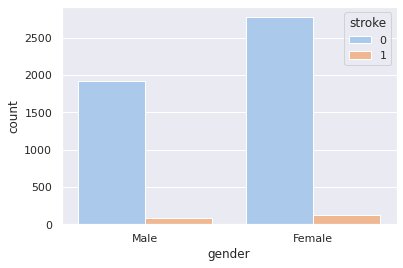

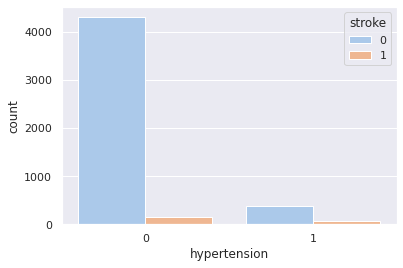

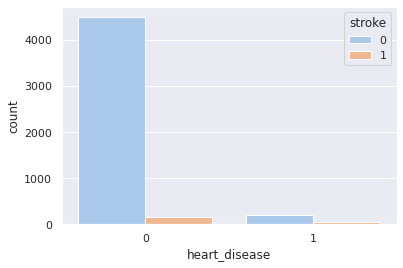

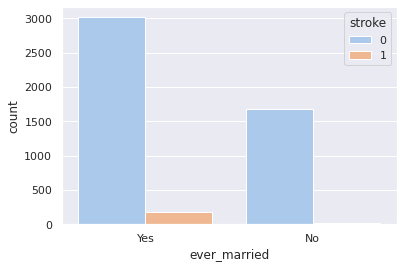

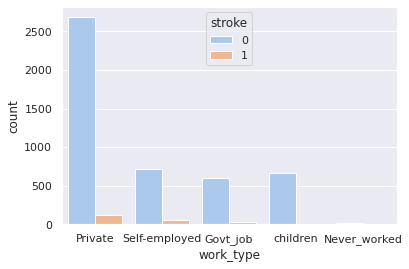

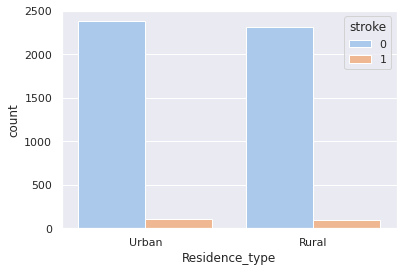

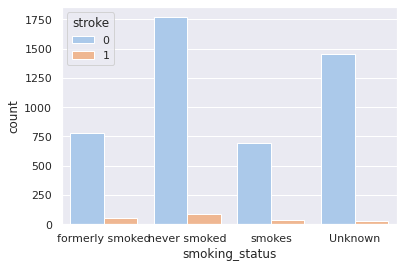

In [28]:
# Bar plots as function of stroke status
categs = ['gender',
          'hypertension',
          'heart_disease',
          'ever_married',
          'work_type',
          'Residence_type',
          'smoking_status']

sns.set_theme(style='darkgrid', palette='pastel')

for cat in categs:
    ax = sns.countplot(data=df, x=cat, hue='stroke')
    plt.show()

Fem ara el mateix amb els atributs numèrics. Al estar les dades desequilibrades, treballarem amb les densitats en lloc dels comptatges

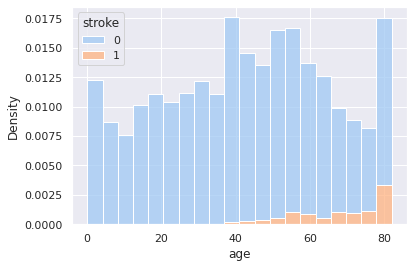

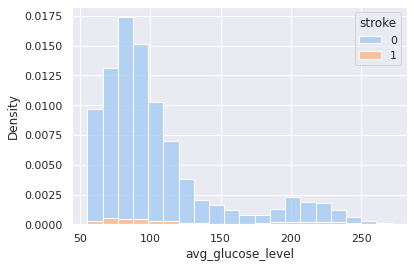

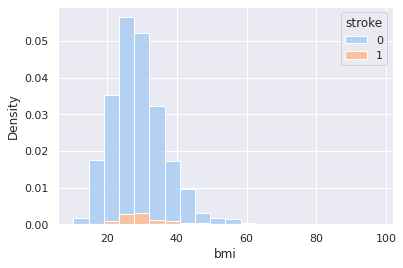

In [29]:
# Histograms as function of stroke status
nums = ['age',
        'avg_glucose_level',
        'bmi']

for num in nums:
    ax = sns.histplot(data=df, 
                      x=num,
                      multiple='stack',
                      bins=20,
                      stat='density',
                      hue='stroke')
    plt.show()

Ja que tindrem en compte totes les variables, categòriques i quantitatives per la predicció de l'esdeveniment d'infart (stroke = 1) o no (stroke = 0), treballarem en la creació d'un classificador de pacients.

## 4.2. Comprovació de la normalitat i homogeneïtat de la variància. 

Comprovarem la normalitat de la variància en les tres variables quantitatives: age, bmi i avg_glucose_level, tot i que com es pot veure als histogrames de l'apartat anterior, podem preveure que no ho seran. 

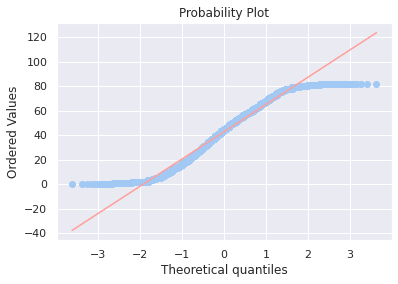

In [39]:
measurements = df['age']
probplot(measurements, dist="norm", plot=pylab)
pylab.show()

L'edat segueix una distribució més tendint a uniforme.

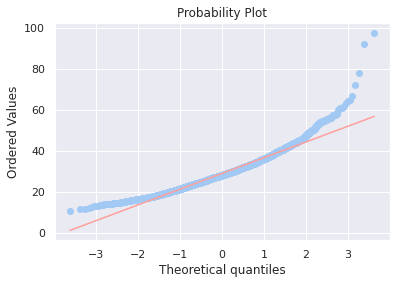

In [41]:
measurements = df['bmi']
probplot(measurements, dist="norm", plot=pylab)
pylab.show()

Veiem que el bmi segueix una distribució lleugerament asimètrica, però bastant normal dins del que cap. Destaquen els outliers que fan que sembli bastant esbiaixada a la dreta.

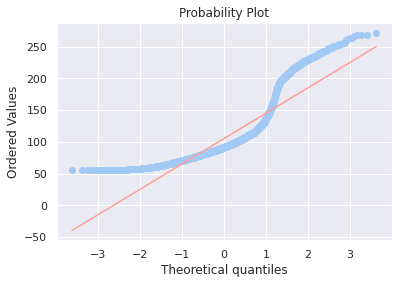

In [40]:
measurements = df['avg_glucose_level']
probplot(measurements, dist="norm", plot=pylab)
pylab.show()

Veiem que el nivell promig de glucosa fa que la distribució sigui bimodal. Es pot veure a l'histograma com hi ha dos pics diferents. Una suposició és que el pic inferior és de el nivell promig de la gent sana, i el pic superior del nivell promig de la gent diabètica.

No ens caldrà normalitzar les dades perquè farem un classificador, així que podem deixar les dades tal qual estan sense haver de tractar-les ni normalitzar-les pel seu estudi. 

## (4.3. - 5.) Aplicació de proves estadístiques per comparar els grups de dades. En funció de les dades i de l’objectiu de l’estudi, aplicar proves de contrast d’hipòtesis, correlacions, regressions, etc. Aplicar almenys tres mètodes d’anàlisi diferents. Representació dels resultats a partir de taules i gràfiques. (Resposta en conjunt perquè és més aclaridor)

Un punt a tractar és la conversió de les variables categòriques a variables numèriques per a que puguin ser interpretades pels classificadors. No caldrà fer-ho per les columnes 'hypertension' o 'heart_disease' perquè ja són de tipus numèric. 

Ho farem amb la tècnica del One-Hot-Encoder. Abans, però, separarem els atributs de les etiquetes.

In [31]:
# Splitting attributes and labels
X = df.drop(['stroke'], axis=1)
y = df['stroke']

# One hot encoding of categorical attributes
X = pd.get_dummies(X, prefix=['gndr', 'marr', 'wrk', 'res', 'smk'])

Ara generem els conjunts d'entrenament i verificació. També estandarditzarem les variables numèriques avg_glucose_level i bmi.

In [32]:
# Selection of numeric attributes
X_num = X[['avg_glucose_level', 'bmi']]

# Standardization of numeric variables
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Dropping of old numerics
X = X.drop(['avg_glucose_level', 'bmi'], axis=1)

# Conversion to np arrays and concatenation
X_np = X.to_numpy()
X_np= np.concatenate((X_np, X_num), axis=1)
 
# Ceating train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_np, y, test_size=0.3, stratify=y, random_state=2021)


Un tema pendent de tractar és el desequilibri entre les dues categories de 'stroke'. Aquesta és una qüestió que no podem obviar ja que el desequilibri entre classes provoca biaixos en la majoria de classificadors a favor de la classe majoritària. Una opció evident seria eliminar instàncies majoritàries fins a igualar el nombre de minoritàries. Però també tenim la opció d'enriquir el dataset mab un major nombre de pacients minoritaris mitjançant SMOTE (Synthetic Minority Oversampling Technique).

La idea de SMOTE consisteix en crear (inventar) noves instàncies minoritàries mitjançant el mètode de KNN. Així, s'agafen els minoritaris, es calcula un KNN de x clusters, i es generen nous minoritaris entre cadascun dels minoritaris primitius i el centroide corresponent. Això és immediat per a variables numèriques; per a datasets amb variables numèriques i categòriques existeix la opció SMOTE-NC. 

Amb aquesta opció, indiquem quínes són les variables categòriques i, per a aquestes, no es calcula una interpolació, es remostreja(copia) directament el valor.


In [33]:
# Create the oversampler 
smotenc = SMOTENC([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], random_state=1963)

# We synthesize new ,  values
X_smt, y_smt = smotenc.fit_resample(X_train, y_train)

# We check average statistics of labels
print('\n\n',y_smt.describe())





 count    6578.000000
mean        0.500000
std         0.500038
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: stroke, dtype: float64


El resultat és un conjunt amb 7518 instàncies euqilibrades per label 50-50. 

Ara el que farem serà comparar els resultats que obtindríem amb un mateix classificador tant amb les dades inicials com amb el nou dataset ampliat. Utilitzarem com classificador patró la regressió logística. 

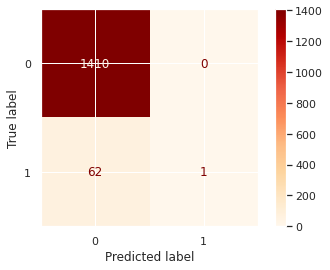

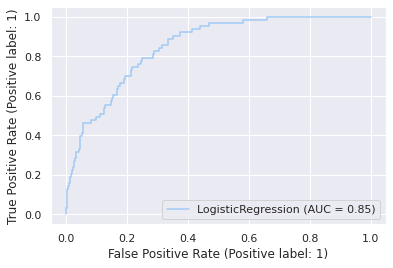

In [34]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test, cmap='OrRd')
plot_roc_curve(clf, X_test, y_test)

Repetim el mateix amb el conjunt ampliat

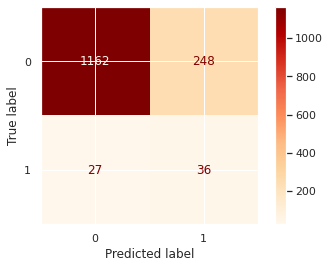

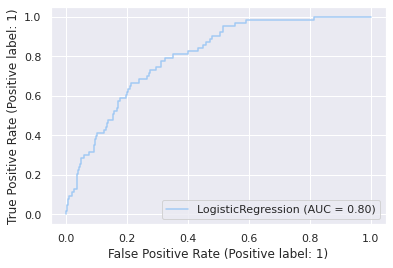

In [35]:
# Logistic classification with enlarged dataset
clf_smt = LogisticRegression(max_iter=1000)
clf_smt.fit(X_smt, y_smt)
plot_confusion_matrix(clf_smt, X_test, y_test, cmap='OrRd')
plot_roc_curve(clf_smt, X_test, y_test)

I ara ens trobem en una situació de compromis: Els resultats són força semblants però en el primer cas, sense ampliar el conjunt de dades, s'obté un nombre de falsos negatius (predicció = 0, real = 1) FN=62 però gairebé no es comet cap altre error, mentre que en el cas ampliat, els FN=27, tot i que també han augmentat molt els falsos positius. En aquest cas potser sempre és millor reduir a la meitat els falsos negatius i donar tractament a la major quantitat de gent, a costa de malbaratar recursos amb els falsos positius que no enviar a casa a 35 pacients amb un AVC! 

Seguirem per tant amb el joc de dades ampliat. Ara el que farem serà verificar els resultats que s'obtenen amb tres altres classificadors. Prendrem 3 dels més clàssics:
* KNN
* SVM
* Decision Tree

In [36]:
# Function definition for plotting results
def viz_results(model):
    model.fit(X_smt, y_smt)
    plot_confusion_matrix(model, X_test, y_test, cmap='OrRd')
    plot_roc_curve(model, X_test, y_test)  

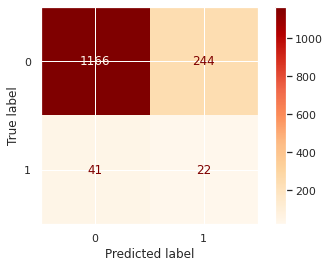

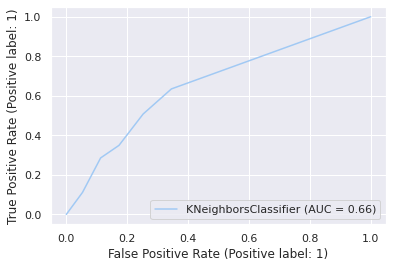

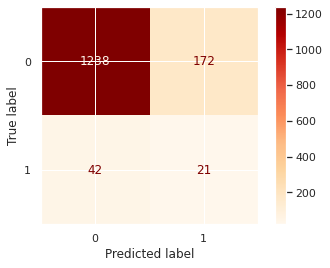

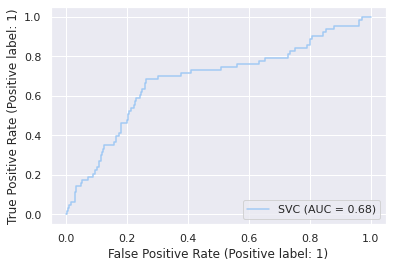

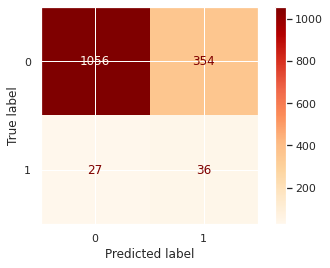

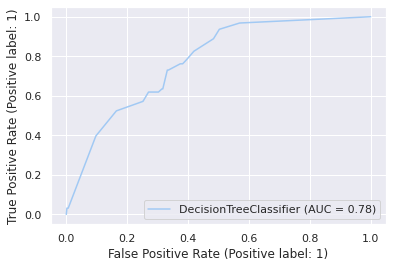

In [37]:
# Models selection
KNN = KNeighborsClassifier()
VecMa = SVC(gamma='auto')
DecTree = DecisionTreeClassifier(max_depth=5)
models = [KNN, VecMa, DecTree]
for model in models:
    viz_results(model)
#viz_results(DecTree)

## 6. Resolució del problema. A partir dels resultats obtinguts, quines són les conclusions? Els resultats permeten respondre al problema? 

| Contribucions | Signa |
| --- | --- |
| Investigació prèvia | jgualob, dhu |
| Redacció de les respostes | jgualob, dhu |
| Desenvolupament codi | jgualob, dhu |